# Multi-agent Reinforcement Learning using PettingZoo: Tic-tac-toe example part I

*Gertjan Verhoeven*

*March 2021*

In this notebook, we will take our first steps into the exciting world of **multi-agent reinforcement learning**. The simplest approach to multi-agent learning is to have the agents learn independently from each other, without having knowledge of each other. From the perspective of the learning agent, the other agents are simply part of the environment. (Literature: Littman 1994, Busoniu 2010).

The notebook uses [PettingZoo](https://www.pettingzoo.ml), a Python library for conducting research in multi-agent reinforcement learning. It's akin to a multi-agent version of OpenAI's Gym library. 

PettingZoo has a large collection of environments (games) available, including Tic-Tac-Toe. We already experimented with Tic-Tac-Toe as part of the introduction chapter of Sutton and Barto. Tic-Tac-Toe therefore seems a natural starting point to start with multi-agent learning.

Before we can start with PettingZoo, we first need to learn about the concept behind the package, which is to model each game as **Agent Environment Cycle (AEC)** games.


# Agent Environment Cycle (AEC) games

From [the paper](https://arxiv.org/abs/2009.13051) by Justin Terry et al:

>The  base  component  of  an  AEC  game  is  a  **changeable  list of agents**.  After the first agent in the list acts, the environment can “act” (allowing agents’ observations to be updated), or the next designated agent can act (skipping environment turns are how truly simultaneous games are depicted). This process continues indefinitely.  

>As  for  reward,  after  every  agent  takes  a  turn  a  “partial” reward is emitted to every other agent. The reward associated with a single action performed by an agent is the total of all the partial rewards following that action and before the agent’s next turn (until this point, the reward is not fully defined).   

>Different aspects of a game will be responsible for different portions of reward. As shown in [this paper], thinking about rewards in this atomized manner instead of lumping the reward process all together can be very helpful.



## PettingZoo: interacting With Environments

Environments can be interacted with using a similar interface to Gym:

```{python}
env.reset()
for agent in env.agent_iter():
    observation, reward, done, info = env.last()
    action = policy(observation, agent)
    env.step(action)
```

The commonly used methods are:

`agent_iter(max_iter=2**63)` returns an **iterator** that yields the current agent of the environment. It terminates when all agents in the environment are done or when `max_iter` (steps have been executed).

`last(observe=True)` returns `observation`, `reward`, `done`, and `info` for the agent currently able to act. The returned reward is the **cumulative reward** that the agent has received since it last acted. If observe is set to `False`, the observation will not be computed, and `None` will be returned in its place. Note that a single agent being done does not imply the environment is done.

Code example:

```{python}
observation, reward, done, info = env.last()
```

`reset()` resets the environment and sets it up for use when called the first time. Only after calling this function do objects like `agents` become available.

`step(action)` takes and executes the action of the agent in the environment, automatically switches control to the next agent.

While developing code, several lower level methods I found useful.

`agent_selection` displays the currently selected agent.

`agents` list all available agents.

The complete API including lower level functionality is at https://www.pettingzoo.ml/api



# Installing PettingZoo

It is best to create a clean Python 3 virtual environment to run this notebook in. 

```
# create venv
python3 -m venv marl-env
# active venv
source marl-env/bin/activate
# upgrade really old pip version on my system
pip install --upgrade pip
# install packages
pip install pettingzoo[classic]
pip install spyder-notebook
pip install dill
```


In [ ]:
!apt-get install python3.9-venv

# create venv
!python3 -m venv marl-env
# active venv
!source marl-env/bin/activate
# upgrade really old pip version on my system
!pip install --upgrade pip
# install packages
!pip install pettingzoo[classic]
!pip install spyder-notebook
!pip install dill

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9 python3.9-distutils
  python3.9-lib2to3 python3.9-minimal
Suggested packages:
  python3.9-doc binfmt-support
The following NEW packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9 python3.9-distutils
  python3.9-lib2to3 python3.9-minimal python3.9-venv
0 upgraded, 7 newly installed, 0 to remove and 37 not upgraded.
Need to get 7,359 kB of archives.
After this operation, 22.7 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.9-minimal amd64 3.9.9-1+bionic2 [789 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 python3.9-minimal amd64 3.9.9-1+bionic2 [1,910 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.9-stdlib amd64 3.9.9-1+

This installs [Spyder](https://www.spyder-ide.org/), the IDE I currently use for Python development, with the Notebook plugin to work both with Python scripts and Jupyter notebooks.

## PettingZoo TicTacToe environment



The TicTacToe environment AEC diagram is depicted below:



![](https://www.pettingzoo.ml/assets/img/aec/classic_tictactoe_aec.svg)

We start with loading the required libraries:

In [ ]:
import random
import numpy as np
from collections import defaultdict
import dill

from pettingzoo.classic import tictactoe_v3

We create an instance of a TicTacToe environment, call `reset()` to initialize the game and list the available agents (players):

In [ ]:
env = tictactoe_v3.env()

env.reset()

env.agents

['player_1', 'player_2']

It helps to understand exactly how the PettingZoo "mechanics" work.

Below we use the `agent_selection` method to show exactly when the active agent switches between the players:

In [ ]:
env.reset()
env.agent_selection

'player_1'

In [ ]:
#env.step()
# env acts by updating the observation and 
# switches to the next player
env.agent_selection



'player_1'

In [ ]:
# now player 2 can act
env.step(1)
env.agent_selection

'player_2'

So, directly after an agent takes an action using `env.step()`, the game moves on to the environent which "acts" by updating the board position, and after that the other player can act.

## Using action masks to choose from available actions

The TicTacToe PettingZoo environment uses so-called "action masks"  to filter out actions that are invalid or not available given the current state of the environment. The action mask is part of the `observation` output from `last()`.


In [ ]:
observation

NameError: ignored

In [ ]:
observation, reward, done, info = env.last()

observation['action_mask']

array([1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

This mask tells us that for the current agent, actions `0` and `1` are not available.
Our `policy()` function needs this information for action selection.

If we choose an illegal action the environment throws an error message and terminates the current game:

In [ ]:
env.reset()
# player 1
env.step(0)
# player 2 attempts same move
env.step(0)


[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.


If `done` is `True` , we can let the agent play action `None`. This allows the agents to keep on stepping until all rewards are received by all agents. 

For example this game where Player 1 plays the winning move:

In [ ]:
env.reset()
env.step(0)
env.step(3)
env.step(1)
env.step(4)
env.step(2)
env.render()

     |     |     
  X  |  O  |  -  
_____|_____|_____
     |     |     
  X  |  O  |  -  
_____|_____|_____
     |     |     
  X  |  -  |  -  
     |     |     


Now the player is Player 2, that receives its (negative) reward for losing the game. Note that it cannot play any legal moves anymore because the game has ended, but we need to call `step()` with action `None` to move back to Player 1:

In [ ]:
observation, reward, done, info = env.last()

print(done)
print(reward)

env.step(None)

True
-1


Player 2 is removed from the list of available agents:

In [ ]:
env.agents

['player_1']

Now player 1 can collect its reward for winning the game!

In [ ]:
observation, reward, done, info = env.last()

print(done)
print(reward)

env.step(None)

True
1


In [ ]:
# no active agents anymore, need to call env.reset() to start a new game
env.agents



[]

In [ ]:
env.reset()
env.render()
env.step(0)
env.render()
env.step(4)
env.render()
env.step(2)
env.render()
env.step(1)
env.render()
env.step(7)
env.render()
env.step(3)
env.render()
env.step(5)
env.render()
env.step(8)
env.render()
env.step(6)
env.render()

observation, reward, done, info = env.last()

print(done)
print(reward)

env.step(None)

observation, reward, done, info = env.last()

print(done)
print(reward)

env.step(None)

     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  X  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  X  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  O  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  X  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  O  |  -  
_____|_____|_____
     |     |     
  X  |  -  |  -  
     |     |     
     |     |     
  X  |  -  |  -  
_____|_____|_____
     |     |     
  O  |  O  |  -  
_____|_____|_____
     |     |     
  X  |  -  |  -  
     |     |     
     |     |     
  X  |  -  |  -  
_____|_____|_____
     |     |     
  O  |  O  |  X  
_____|_____|_____
     |     |     
  X  |  -  |  -  
     |     |     
     |     |     
  X  |  O 

# Exercise 1 Random play

When two players who play completely randomly play Tic-Tac-Toe, the first player wins 58.49% of the time, the second player wins 28.81% of the time, and the game is a draw 12.70% of the time. 

Code up a function that has both players play a random policy for 10.000 games.
Store the outcomes of the games (W/D/L) for both Players.
Check your work by comparing with the percentages above.


In [ ]:
# use this as starting point

def policy(observation, agent):
  action = random.choice(np.flatnonzero(observation['action_mask']))
  return action

env.reset()
for agent in env.agent_iter():
  observation, reward, done, info = env.last()
  action = policy(observation, agent) if not done else None
  env.step(action)
  print(reward)
  # env.render() # this visualizes a single game


0
0
0
0
0
0
0
-1
1


## Play random for 10 000 games & store outcomes

In [ ]:
outcomes = {"player_1" : 0., "player_2" : 0.}
for i in range(10000):
  env.reset()
  for agent in env.agent_iter():
    observation, reward, done, info = env.last()
    action = policy(observation, agent) if not done else None
    outcomes[env.agent_selection] += max(reward, 0)
    env.step(action)
p1 = outcomes["player_1"]/100
p2 =outcomes["player_2"]/100
draw =0.01*(10000 - outcomes["player_1"] - outcomes["player_2"])
print("The first player wins", p1,"% of the time, the second player wins", p2,"% of the time, and the game is a draw", draw,"% of the time. ")

The first player wins 57.57 % of the time, the second player wins 29.74 % of the time, and the game is a draw 12.69 % of the time. 


# Hashing the board position to a key for use in a dictionary

In the TicTacToe environment, observations of agents consist of a complete description of the board position. An observation of the board is a 3D array and looks like this:

In [ ]:
env.reset()
observation, reward, done, info = env.last()


observation['observation']

array([[[0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0]]], dtype=int8)

Compare this to the properly rendered board position:

In [ ]:
env.render()

     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     


For Q-learning, we need the environment to store Q-values for each unique board position. A convenient way to create unique identifiers for all board positions is to use a **hash-function**.

We encountered this concept at the beginning of the course:

>*Hash functions* are used to transform a large amount of data (such as a complete board position aka game state) into a single number.
The special thing about hash functions is that every board position is transformed into a unique number, i.e. there are no two board positions that are transformed to the same unique number.
This allows us to use this to label / identify each board position, and use this as an identifier to store information about that board position.

Example code (first convert observation to string, then hash):

In [ ]:
state = hash(str(observation['observation']))

state

-582640870111660086

**Update:** 
I discovered that in Python 3, the `hash()` function is, by design, not reproducible between python sessions! This makes it unsuitable for our purpose, since we want to learn an optimal policy for each state, and save that policy (the Q-table) to disk for later use. 
This later use will consist of things like testing the policy's performance, or as an AI player to play against ourselves.

To have reproducible hashing we can use `hashlib`, a Python library containing various hashing algorithms. I chose the `MD5` algorithm:

In [ ]:
import hashlib

def encode_state(observation):
    # encode observation as bytes           
    obs_bytes = str(observation).encode('utf-8')
    # create md5 hash
    m = hashlib.md5(obs_bytes)
    # return hash as hex digest
    state = m.hexdigest()
    return(state)

encode_state(observation['observation'])

'65ea394aefe804468cc42b20ecc8b606'

To make self-play (An single agent that plays against itself) easy to implement, in PettingZoo the observation contains information about which player is making the observation. This information is encoded in the observation by flipping the board position player index order (aka "inverting the channels").

Take for example the observation of the board state after Player 1 made a first move:

In [ ]:
env = tictactoe_v3.env()
env.reset()
env.step(4)
env.observe('player_1')['observation']

array([[[0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [1, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0]]], dtype=int8)

Now compare this with how Player 2 observes the same board position:

In [ ]:
env.observe('player_2')['observation']

array([[[0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 1],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0]]], dtype=int8)

In practice, this is only an issue if both players see the same board position, which only occurs at the end of a game, when the players collect their rewards. 

In [ ]:
env = tictactoe_v3.env()
env.reset()
env.step(0)
env.step(6)
env.step(1)
env.step(5)
env.step(2)

env.observe("player_1")['observation']

array([[[1, 0],
        [1, 0],
        [1, 0]],

       [[0, 0],
        [0, 0],
        [0, 1]],

       [[0, 1],
        [0, 0],
        [0, 0]]], dtype=int8)

In [ ]:
env.step(None)
env.observe("player_2")['observation']

array([[[0, 1],
        [0, 1],
        [0, 1]],

       [[0, 0],
        [0, 0],
        [1, 0]],

       [[1, 0],
        [0, 0],
        [0, 0]]], dtype=int8)

To avoid double counting of end-game board positions, I used this trick:

In [ ]:
state = encode_state(env.render(mode = 'ansi'))

state

'6c2e7780c70c674fc2c99fb84f81de15'

# Exercise 2 Hashing and dictionaries for the Q-table

For this exercise, adapt your code from Exercise 1 to add a  `defaultdict` dictionary that contains the value `0` for each board position (identified using `encode_state()` ) the agents encounter. 

Run your code for 20.000 games with the agents playing a random policy to find out how many distinct states Tic-Tac-Toe contains. The dictionary should max out at 5478 different states.

You can use the code provided below.

In [ ]:
from collections import defaultdict
def example():
  env.reset()

  Q = defaultdict(lambda: np.zeros(nA)) 

  # reminder about how default dict works

  Q['32433'] = 0
  Q['-5323'] = 0
  Q['2397887'] = 0

  Q
example()

In [ ]:
Q = defaultdict()
# Q['32433'] = 0
# Q['-5323'] = 0
# Q['2397887'] = 0
print(Q) 
Q_list = []
for i in range(20000):
  env.reset()
  for agent in env.agent_iter():
    observation, reward, done, info = env.last()
    action = policy(observation, agent) if not done else None
    # outcomes[env.agent_selection] += max(reward, 0)
    state = encode_state(env.render(mode = 'ansi'))
    Q[state] = 0
    env.step(action)
  Q_list.append(len(Q))
print(len(Q))

defaultdict(None, {})
5478


Ci dessous le nombre d'états trouvés au cours des 20 000 parties.

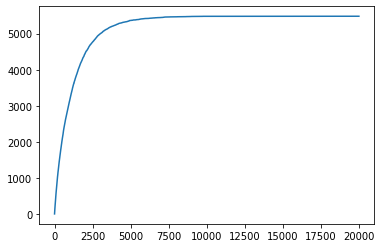

In [ ]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(20_000)], Q_list)

## License

The code in this notebook is copyrighted by Gertjan Verhoeven and licensed under the new BSD (3-clause) license:

https://opensource.org/licenses/BSD-3-Clause

The text and figures in this notebook (if any) are copyrighted by Gertjan Verhoeven and licensed under the CC BY-NC 4.0 license:

https://creativecommons.org/licenses/by-nc/4.0/